# Approximating the Area of a Minimum Bounding Polygon

Let $S$ be a collection of $n$ points in $R^2$ contained by the square space $[0, a] \times [0, a]$. 

1. Identify the subset $B \subseteq S$ that represent the vertices of the smallest possible convex polygon that contains the remaining points (if any) in $S-B$.

2. Given an additional point $(x, y)$ within $[0, a] \times [0, a]$, determine if this point is contained within the polygon or not.

3. Approximate the area of the minimum bounding polygon. (Note: there are many ways to find this area exactly using geometric/trigonometric formulas, such as Herron's formula - we're interested in determining a way in which me might *approximate* the area)

For our example, we'll consider a set of $n=10$ points contained within $[0, 10] \times [0, 10]$. We'll also only randomly select points with integer coordinates for simplicity.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

### Creating the Points

In [2]:
n = 10     # number of points in the plane
a = 10    # side length of boundary square [0, a] x [0, a]

In [3]:
X = np.random.randint(0, a, size=n)
Y = np.random.randint(0, a, size=n)
S = list(zip(X, Y))

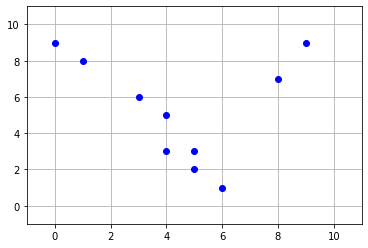

In [4]:
# plot points
for pt in S:
    plt.plot(pt[0], pt[1], 'bo')

plt.grid(True)
plt.xlim(-1, a+1)
plt.ylim(-1, a+1)

plt.show()

## Part 1 - Locating the vertices of the bounding polygon

### How to Locate the Vertices

All points that have a max or min x or y coordinate are guaranteed to be vertices. Therefore, the top, bottom, leftmost, or rightmost points are guaranteed to be vertices and can be used as a starting spot. (And if there is ever a tie for top/bottom/leftmost/rightmost, then all members of the tie are guaranteed to be vertices.)

Let's start by identifying the "bottom" vertex of our polygon, then rotating in a counterclockwise direction.  If there are multiple "bottom" vertices with the same minimal $y$ value, we want to select the one with the largest $x$ value since we'll be searching in a CCW direction. 

To find the next sequential vertex point, imagine a ray from the current vertex at an angle of $ 0^{\circ}$. We'll want the angle of this ray to increase until it hits a point - this point will be the next vertex. To do this, begin with an initial angle of $0^{\circ}$ and compute the angles between the currently vertex and all other points. The one with the next largest angle relative to the previously traveled angle will be the next vertex. Repeat this until the original starting vertex is chosen as the next vertex.


### Setup

In [5]:
thetaList = []
vertices = []

# find all bottom-row points, select the one with the largest x val
bottomPoints = [s for s in S if s[1] == min(Y)]
currVert = max(bottomPoints, key=lambda s: s[0])

# start out sweeping search at an angle of 0deg from first vertex
theta = 0

thetaList.append(theta)
vertices.append(currVert)

# don't modify S, keep list of original points available
# leave starting vert in available points so it can be found
#  a second time to end the search. all other found verts will
#  be removed from available points as they're found.
points = S[:]

### Finding the Vertices

In [6]:
# when our "next" vertex is actually the original first vertex, we're done
while vertices[0] != vertices[-1] or len(vertices) == 1:
    
    # find angles to all points; build list anglePts = [(angle, (x, y)), ...]
    cx, cy = currVert
    anglePts = []
    for pt in points:
        px, py = pt
        if pt != (cx, cy):
            ang = np.arctan2(py-cy, px-cx)*180/np.pi
            if ang <= 0:
                ang += 360
            anglePts.append((ang, pt))
    
    # sort the angles list so the smallest angle is first
    anglePts.sort()
    
    # we want the angle that has the *next* largest angle relative to the previous angle
    possAngs = [ap for ap in anglePts if ap[0] >= theta]
    nextAng = possAngs[0]
    theta, currVert = nextAng
    
    # include the new point in the vertex list, remove it from possible-to-select points
    thetaList.append(theta)
    vertices.append(currVert)
    points.remove(currVert)
 
print('Vertices of the polygon, in order:')
vertices

Vertices of the polygon, in order:


[(6, 1), (9, 9), (0, 9), (4, 3), (5, 2), (6, 1)]

### Graphing the Polygon

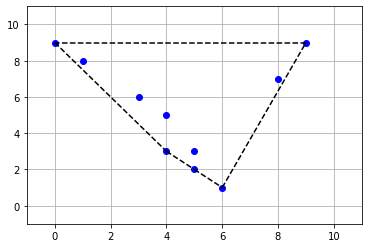

In [7]:
# plot points
for pt in S:
    plt.plot(pt[0], pt[1], 'bo')
    
# plot edges
for i in range(len(vertices)-1):
    (x0, y0), (x1, y1) = vertices[i], vertices[i+1]
    plt.plot([x0, x1], [y0, y1], 'k--')
    
plt.grid(True)
plt.xlim(-1, a+1)
plt.ylim(-1, a+1)

plt.show()

## Part 2 - Identify whether an arbitrary point is contained within the polygon

### How to determine containment

Any point that is *not* contained within the polygon is able to "view" the entire polygon within a $180^\circ$ span.  We can find the angle from the point to all vertices of the polygon; if the span is less than $180^\circ$, the point is not contained.

Note that we'll get some issues wrapping around from $359^{\circ}$ to $0^{\circ}$.  

### Creating test points
Our test points will be random uniform points rather than integers

In [8]:
m = 2000   # number of test points for inside/outside
testX = np.random.rand(m)*a
testY = np.random.rand(m)*a
testS = list(zip(X, Y))

### Identifying which points are contained

In [9]:
# each test point (tx, ty) will be sorted into the list of points "in" or "out" of the polygon
ins = []
outs = []

for i in range(m):
    
    tx, ty = testX[i], testY[i]
    
    # If test point is actually a vertex, skip it (not classified as in or out)
    if (tx, ty) in vertices:
        continue
    
    # Find angles from test point to all vertices
    angles = []
    for vt in vertices:
        vx, vy = vt
        ang = np.arctan2(vy-ty, vx-tx)*180/np.pi
        if ang <= 0:
            ang += 360
        angles.append(ang)
            
    # Because our polygon is convex, there can never be more than 180deg diff between two vertices
    # Therefore, we find the appropriate coterminal angle that IS within -180 < theta < 180 when we
    #  take our differences
    angleDiffs = []
    for i in range(len(angles)-1):
        diff = angles[i+1] - angles[i]
        if diff < -180:
             diff += 360
        elif diff > 180:
            diff -= 360
        angleDiffs.append(diff)
        
    # Now, consider yourself standing at the given test point, and your goal is to look at every vertex in order
    # If you are inside the polygon, you'll need to turn a full 360 degrees to see every vertex in order
    # If you are outside the polygon, you'll do some pos, some neg turning, for a net turn of 0 deg
    
    totalTurn = round(sum(angleDiffs))
    if totalTurn == 360:
        ins.append((tx, ty))
    else:
        outs.append((tx, ty))
        
        

### Plotting everything

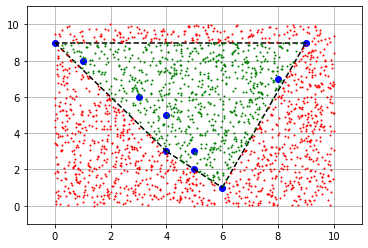

In [10]:
# plot original points
for pt in S:
    plt.plot(pt[0], pt[1], 'bo')
    
# plot edges between vertices
for i in range(len(vertices)-1):
    (x0, y0), (x1, y1) = vertices[i], vertices[i+1]
    plt.plot([x0, x1], [y0, y1], 'k--')
    
# plot test points
for pt in ins:
    plt.plot(pt[0], pt[1], 'go', markersize = 1)
for pt in outs:
    plt.plot(pt[0], pt[1], 'ro', markersize = 1)
    
plt.grid(True)
plt.xlim(-.1*a, 1.1*a)
plt.ylim(-.1*a, 1.1*a)

plt.show()

## Part 3 - Approximate the area of the polynomial

Now that we can determine if an arbitrary point is contained within the polygon, we can estimate the area of the polynomial.  To do this, note that the proportion of the area that the polygon takes up out of the original $ a \times a $ square should be equal to the proportion of points that fell inside of the polygon.

So, let's divide the "ins" count by the total number of points (the proportion of points inside), and multiply that proportion by the total area, to arrive at an area estimate for the polygon.

In [11]:
totalArea = a**2
inCount = len(ins)
proportionContained = inCount/m
polygonArea = proportionContained*totalArea

print(f'Number of Test Points:\t{m}')
print(f'Number Contained:\t{inCount}')
print(f'Proportion contained:\t{proportionContained}')
print()
print(f'Total Available Area:\t{totalArea}')
print(f'Polygon Area Estimate:\t{polygonArea}')

Number of Test Points:	2000
Number Contained:	754
Proportion contained:	0.377

Total Available Area:	100
Polygon Area Estimate:	37.7


### Okay! Let's summarize this all within a single function so we can check out lots of cases more quickly

In [12]:
def min_bounding_polygon(n=10, m=1000, a=10):
    
    ##########
    # This function takes in:
    #   n: number of initial points from which vertices will be found
    #   m: number of test points to use in area approximation
    #   a: side length of bounding square [0, a] x [0, a]
    #
    # This function's primary purpose is to print output and display a graph,
    #  but it also returns:
    #   vertices: list of (x, y) ordered pairs of vertex locations, in order
    #   ins: list of (x, y) points determined to be within the polygon
    #   outs: list of (x, y) points determined to be outside the polygon
    #   polygonArea: estimate of the area of the minimum bounding polygon
    ##########
    
    # setup "actual" points and some lists
    X = np.random.randint(0, a, size=n)
    Y = np.random.randint(0, a, size=n)
    S = list(zip(X, Y))
    thetaList = []
    vertices = []
    bottomPoints = [s for s in S if s[1] == min(Y)]
    currVert = max(bottomPoints, key=lambda s: s[0])
    theta = 0
    thetaList.append(theta)
    vertices.append(currVert)
    points = S[:]
    
    # find vertices
    while vertices[0] != vertices[-1] or len(vertices) == 1:
        cx, cy = currVert
        anglePts = []
        for pt in points:
            px, py = pt
            if pt != (cx, cy):
                ang = np.arctan2(py-cy, px-cx)*180/np.pi
                if ang <= 0:
                    ang += 360
                anglePts.append((ang, pt))
        anglePts.sort()
        possAngs = [ap for ap in anglePts if ap[0] >= theta]
        nextAng = possAngs[0]
        theta, currVert = nextAng
        thetaList.append(theta)
        vertices.append(currVert)
        points.remove(currVert)
    
    # classify test points
    testX = np.random.rand(m)*a
    testY = np.random.rand(m)*a
    testS = list(zip(X, Y))
    ins = []
    outs = []
    for i in range(m):
        tx, ty = testX[i], testY[i]
        if (tx, ty) in vertices:
            continue
        angles = []
        for vt in vertices:
            vx, vy = vt
            ang = np.arctan2(vy-ty, vx-tx)*180/np.pi
            if ang <= 0:
                ang += 360
            angles.append(ang)
        angleDiffs = []
        for i in range(len(angles)-1):
            diff = angles[i+1] - angles[i]
            if diff < -180:
                 diff += 360
            elif diff > 180:
                diff -= 360
            angleDiffs.append(diff)
        totalTurn = round(sum(angleDiffs))
        if totalTurn == 360:
            ins.append((tx, ty))
        else:
            outs.append((tx, ty))
            
    # compute results, print output, create graph
    totalArea = a**2
    inCount = len(ins)
    proportionContained = inCount/m
    polygonArea = proportionContained*totalArea

    print(f'Number of Test Points:\t{m}')
    print(f'Number Contained:\t{inCount}')
    print(f'Proportion contained:\t{proportionContained}')
    print()
    print(f'Total Available Area:\t{totalArea}')
    print(f'Polygon Area Estimate:\t{polygonArea}')

    for pt in S:
        plt.plot(pt[0], pt[1], 'bo')
    for i in range(len(vertices)-1):
        (x0, y0), (x1, y1) = vertices[i], vertices[i+1]
        plt.plot([x0, x1], [y0, y1], 'k--')
    for pt in ins:
        plt.plot(pt[0], pt[1], 'go', markersize = 1)
    for pt in outs:
        plt.plot(pt[0], pt[1], 'ro', markersize = 1)
    plt.grid(True)
    plt.xlim(-.1*a, 1.1*a)
    plt.ylim(-.1*a, 1.1*a)
    plt.show()

    return vertices, ins, outs, polygonArea

Number of Test Points:	1500
Number Contained:	844
Proportion contained:	0.5626666666666666

Total Available Area:	62500
Polygon Area Estimate:	35166.666666666664


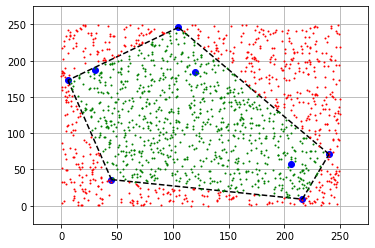

In [13]:
verts, ins, outs, area = min_bounding_polygon(n=8, m=1500, a=250)